## <font color= darkblue> Aplicación de Ciencia de Datos para la Clasificación del Movimiento Diario del Bitcoin</font>
\author{Agustin Muñoz Gonzalez} \date{July 2021}

\maketitle
\makeatletter
\renewcommand{\@seccntformat}[1]{}
\makeatother

En este trabajo se intentará dar un overview sobre distintos modelos de la ciencia de datos aplicados al problema de clasificación binaria del movimiento diario futuro del BTC/USD.

Para ello consideraremos una serie de variables explicativas que consideramos relevantes para el problema en cuestión. Para respaldar tal información mencionaremos los trabajos y bibliografías pertinentes.

# <font color= darkblue> Part I: Exploratory Data Analysis & Engineering Data Features</font>


### <font color= darkblue>Financial Data Preprocessing, Feature Engineering and Feature Learning</font>

A time series is a series of data points indexed in time order. Financial Data such as bitcoin price series observed at equally spaced points in time are an example of such a series. It is a sequence of observations recorded at regular time intervals and depending on the frequency of observations, a time series may typically be in seconds, minute, hourly, daily, weekly, monthly, quarterly and annually. In Marcos Lopez de Prado words "Finance is not a plug-and-play subject as it relates to machine learning. Modelling financial series is harder than driving cars or recognizing faces."

The first step towards any data analysis would be to parse the raw data which involves extracting the data from the source and then cleansing and filling the missing data, if any. While data comes in many forms, Python makes it easy to read time series data using useful packages.

We use pandas-datareader library to retrieve historical data from investpy, a Python package for historical data extraction from cryptocurencies, funds, ETFs. 

### <font color= darkblue>Importing required libraries</font>
We initially import several python packages in order to view, explore, analyze, visualize results and measure performance speeds on the data. We also import additional modules from various subpackages of Keras that will be used for building the various neural networks and will be explained in more detail when encountered.

In [90]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import math
import investpy
# Import preprocessor from sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Import from keras
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
from keras.layers import Dropout, Dense, LSTM

# Import cufflinks for visualization
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] =(20,10)
plt.style.use('fivethirtyeight')

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')


# Fijo una semilla para que los resultados sean reproducibles. Recordemos que las NN arrancan con random weights (entre otras cantidades random)
# Me baso en https://medium.com/@ODSC/properly-setting-the-random-seed-in-ml-experiments-not-as-simple-as-you-might-imagine-219969c84752
# Set a seed value
seed_value= 123
# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)
# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)
# 4. Set `tensorflow` pseudo-random generator at a fixed value
# import tensorflow as tf
# tf.set_random_seed(seed_value)

from numpy.random import seed
seed(123)

#### <font color= darkblue> Data Collection</font>
Hemos basado este trabajo en datos descargados mediante una API key gratuita del exchange Bitstamp, vı́a quandl.com, y en datos del sitio investing.com AGREGAR SITIO DE ON_CHAIN. Hemos utilizado datos históricos con frecuencia temporal diaria desde el 23 de Febrero del 2017 hasta el 15 de Marzo del 2021. Es decir, alrededor de 1000 datos.

In [91]:
Bitcoin=pd.read_csv('data/BITSTAMP-USD.csv', index_col=0, parse_dates=True).dropna()
Bitcoin = Bitcoin[::-1]

#### <font color= darkblue>Visualising Bitcoin Prices fluctations</font>

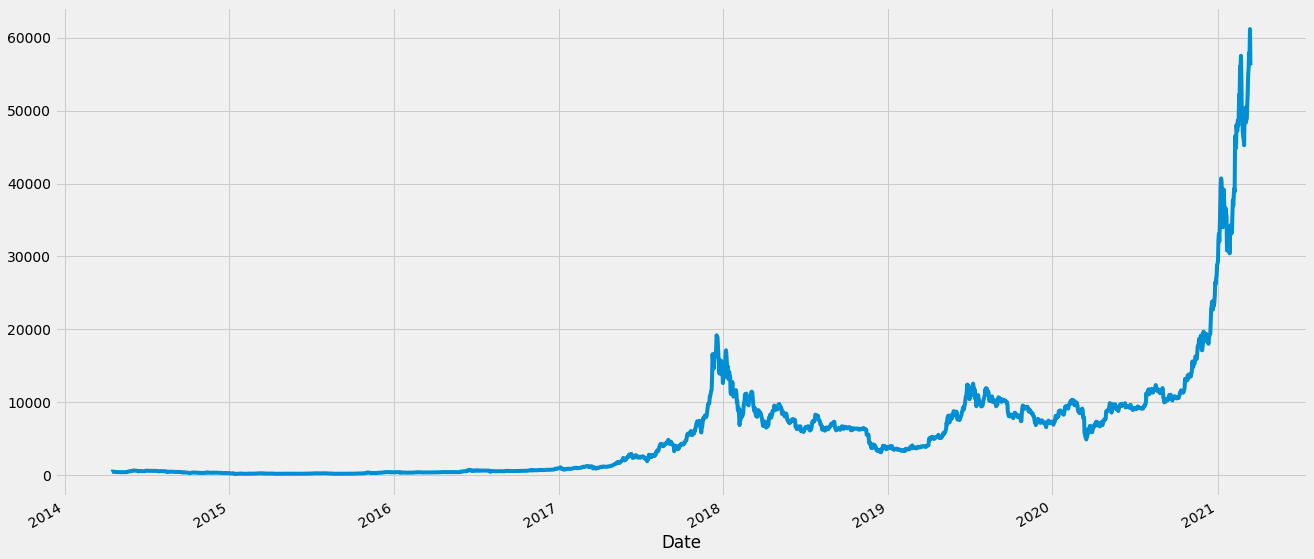

In [92]:
Bitcoin['Last'].plot(figsize=(20,10));

Dado que no esta tan claro qué factores afectan el precio de Bitcoin nos parece apropiado cubrir 3 aspectos:

\begin{itemize}
\item factores relevantes del spot price de bts tales como: Futuros de BTC y Ethereum;
\item indicadores macro de los mercados: pares de fx representativos, commodities como el crudo, TY10 y el indice de volatilidad;
\item indicadores tecnicos tipicos asociados a volumen, momentum, volatiliad y datos de velas;
\item métricas on chain, i.e. métricas propias de la block chain.
\end{itemize}

#### <font color= darkblue> Adding different types of features – Market Prediction with more Features</font>
<table>
<thead><tr>
<th style="text-align:left">Symbol</th>
<th style="text-align:left">Description</th>   
</tr>
</thead>
<tbody>
<tr>
<td style="text-align:left">CME_BitcoinFutures</td>
<td style="text-align:left">Contratos futuros diarios del BTC. </td>   
</tr>    
<tr>    
<td style="text-align:left">ETH</td> 
<td style="text-align:left">Datos de cierre diario de Ethereum</td>    
</tr>    
<tr> 
<td style="text-align:left">DXY, EUR_JPY, GBP_CAD, AUD_CHF</td>
<td style="text-align:left">El índice del dólar y algunas relaciones entre divisas</td>      
</tr>    
<tr>     
<td style="text-align:left">CRUDE, Gold, Treasury_10</td>
<td style="text-align:left">Futuros de oil y de oro, y precios de cierre del yield del tesoro americano a 10 años</td>     
</tr>    
<tr>       
<td style="text-align:left">VIX</td>
<td style="text-align:left">Indice de volatilidad diaria del mercado</td>       
</tr>    
<tr>      
<td style="text-align:left">ATR</td>
<td style="text-align:left">El Average True Range (ATR) es un indicador de volatilidad usado en el análisis técnico </td>       
</tr>    
<tr>     
<td style="text-align:left">OBV</td>
<td style="text-align:left">On-balance volume (OBV) es un indicador técnico de momentum que utiliza el volumen diario del BTC</td>     
</tr>    
<tr>       
<td style="text-align:left">sma14, sma60</td>
<td style="text-align:left">Medias móviles a 14 y 60 días del precio de cierre diario del BTC</td>       
</tr>        
<tr>    
<td style="text-align:left">vol14, vol60</td>
<td style="text-align:left">Indices de volatilidad implícitas de 14 y 60 días de los retornos diarios del BTC</td>    
</tr>       
<tr>    
<td style="text-align:left">sma20,b_upper,b_lower</td>
<td style="text-align:left">Las Bollinger Bands son otro indicador técnico utilizado para medir la sobrecompra o sobreventa de un activo. En este caso, lo hemos aplicado al precio de cierre diario del BTC </td>      
</tr>    
<tr>         
<td style="text-align:left">MOM5D, STD21</td>
<td style="text-align:left">Momentum a 5 días y desviación estándar a 21 días del precio de cierre y del retorno diario del BTC, resp.</td> 
</tr> 
<tr>    
<td style="text-align:left">High, Low, Last, Bid, Ask, VWAP, volume </td>
<td style="text-align:left"> Datos técnicos y de velas típicos del precio diario del BTC</td>   
</tr>
<tr>     
<td style="text-align:left">Returns </td>
<td style="text-align:left"> Retornos diarios del BTC respecto del día anterior</td>    
</tr>
<tr>     
<td style="text-align:left">MVRV_FF</td>
<td style="text-align:left"> COMPLETAR</td>    
</tr>
<tr>     
<td style="text-align:left">HashRate </td>
<td style="text-align:left"> COMPLETAR</td>    
</tr>
<tr>     
<td style="text-align:left">Miner_revenue </td>
<td style="text-align:left"> COMPLETAR</td>    
</tr>
<tr>    
</tbody>
</table>     


Definimos las funciones que usaremos para el cálculo de algunas de las features anteriores.

In [93]:
def ATR(df,n):
    "function to calculate True Range and Average True Range"
    df = df.copy() # Se asume que el orden de df es creciente en fechas (ie las primeras fechas son las mas viejas), sino van a haber elementos nans en las fechas mas recientes y uno quiere nans en las mas antiguas

    df['H-L']  = abs(df['High']-df['Low'])
    df['H-PO'] = abs(df['High']-df['Open'].shift(1))
    df['L-PO'] = abs(df['Low']-df['Open'].shift(1))
    
    df['TR']   = df[['H-L','H-PO','L-PO']].max(axis=1,skipna=False)
    df['ATR']  = df['TR'].rolling(n).mean()

    df2 = df.drop(['H-L','H-PO','L-PO'],axis=1)
    return df2

def OBV(df):
	n=len(df)
	OBV=[]
	OBV.append(0)
	for i in range(0,n-1):
		if df['Price'][i]<df['Price'][i+1]:
			OBV.append(OBV[i]+df['Volume'][i+1])
		elif df['Price'][i]>df['Price'][i+1]:
			OBV.append(OBV[i]-df['Volume'][i+1])
	return OBV

# Vamos a transformar los elementos de Bitcoin['CME_BitcoinFutures'] y Bitcoin['ETH'] de string a float. OJO! No anda si el dataframe tiene NANs
def text_currency_to_float(text):
  t = text
  dot_pos = t.rfind('.')
  comma_pos = t.rfind(',')
  if comma_pos > dot_pos:
    t = t.replace(".", "")
    t = t.replace(",", ".")
  else:
    t = t.replace(",", "")

  return(float(t))

Cargamos los demás datos necesarios.

In [94]:
#DXY
DXY=pd.read_csv('data/US Dollar Index Historical Data.csv', index_col=0, parse_dates=True).dropna()
DXY=DXY.rename(columns={'Price':'Close'})

# Delete data rows with nan values
DXY=DXY.dropna() 
# TENER EN CUENTA QUE POR LA SMA60 Y VOL60 HAY 60 ELEMENTOS DE LA SAMPLE ORIGINAL QUE SE PIERDEN
DXY=DXY[::-1] # Lo dejo ordenado de forma decreciente xq el resto del programa lo hice con esta asunción

# Otras
EUR_JPY=pd.read_csv('data/EUR_JPY Historical Data.csv', index_col=0, parse_dates=True).dropna()['Price']
GBP_CAD=pd.read_csv('data/GBP_CAD Historical Data.csv', index_col=0, parse_dates=True).dropna()['Price']
AUD_CHF=pd.read_csv('data/AUD_CHF Historical Data.csv', index_col=0, parse_dates=True).dropna()['Price']
CRUDE=pd.read_csv('data/Crude Oil WTI Futures Historical Data.csv', index_col=0, parse_dates=True).dropna()['Price']
Treasury_10=pd.read_csv('data/United States 10-Year Bond Yield Historical Data.csv', index_col=0, parse_dates=True).dropna()['Price']
VIX=pd.read_csv('data/CBOE Volatility Index Historical Data.csv', index_col=0, parse_dates=True).dropna()['Price']

# GOLD
Gold=pd.read_csv('data/Gold Futures Historical Data.csv', index_col=0, parse_dates=True, thousands=',').dropna()
# HAY UN TEMA CON EL VOLÚMEN Y ES QUE NO HAY DATOS RECIENTES CON LO CUAL EN LA CONVERSIÓN QUE HACEMOS MAS ADELANTE VAMOS A TENER nans Y CUANDO SAQUEMOS ESOS DATOS VAMOS A PERDER INFO RECIENTE
Gold = Gold[::-1]

# Para volumen (K --> 10**3)
def value_to_float(x):
    if type(x) == float or type(x) == int:
        return x
    if 'K' in x:
        if len(x) > 1:
            return float(x.replace('K', '')) * 1000
        return 1000.0

Gold=Gold.dropna()
Gold=Gold[::-1] # Lo dejo ordenado de forma decreciente xq el resto del programa lo hice con esta asunción

Procedemos a armar el dataframe con todos las features y la muestra de datos por un lado, y un dataframe con la variable respuesta correspondiente por otro.

In [95]:
# Retornos de Bitcoin
rt_Bitcoin=np.around(Bitcoin['Last'].pct_change().dropna(),3)#.reindex(index=rt_BBAR.index[::-1])
# Acomodamos las dimensiones
Bitcoin=Bitcoin.rename(columns={'Last':'Open'}) # Le tengo que poner 'Open' xq la función ATR usa eso!
ATR_Bitcoin = ATR(Bitcoin,21)['ATR']
Bitcoin=Bitcoin.rename(columns={'Open':'Last'}) # Le vuelvo a poner 'Last'
Bitcoin['Returns']=rt_Bitcoin
Bitcoin['ATR']=ATR_Bitcoin
Bitcoin['OBV']=OBV(Bitcoin[::-1].rename(columns={'Last':'Price'}))[::-1] # Le tengo que poner 'Price' porque OBV pide eso; Ademas como los primeros elementos de Bitcoin son las fechas mas actuales, tengo que aplicar OBV a Bitcoin[::-1]. Por ultimo para que la columna OBV respete el orden de fechas de Bitcoin, de nuevo tengo que aplicar [::-1] a lo que devuelve la funcion OBV
# Features relevantes para el spot price 
Bitcoin['CME_BitcoinFutures']=pd.read_csv('data/Bitcoin Futures CME Historical Data.csv', index_col=0, parse_dates=True).dropna()['Price']
Bitcoin['ETH']=pd.read_csv('data/Ethereum Historical Data.csv', index_col=0, parse_dates=True).dropna()['Price']
# Features macro
Bitcoin['DXY']=pd.read_csv('data/US Dollar Index Historical Data.csv', index_col=0, parse_dates=True).dropna()['Price']
Bitcoin['EUR_JPY']=EUR_JPY
Bitcoin['GBP_CAD']=GBP_CAD
Bitcoin['AUD_CHF']=AUD_CHF
Bitcoin['CRUDE']=CRUDE
#Bitcoin['Gold']=pd.read_csv('Gold Futures Historical Data.csv', index_col=0, parse_dates=True, thousands=',').dropna()['Price']
Bitcoin['Treasury_10']=Treasury_10
Bitcoin['VIX']=VIX

# Features Técnicos
# Simple Moving Averages
# 2 week
# ACA NECESITO LLEGAR CON Bitcoin ORDENADO AL REVES (DATOS MAS VIEJOS AL PRINCIPIO)
Bitcoin['sma14'] = Bitcoin['Last'].rolling(14).mean()
# 2 month
Bitcoin['sma60'] = Bitcoin['Last'].rolling(60).mean()

# Rolling Volatility (annualized assuming 365 trading days)
# 2 week
Bitcoin['vol14'] = Bitcoin['Returns'].rolling(14).std() * np.sqrt(365)
# 2 month
Bitcoin['vol60'] = Bitcoin['Returns'].rolling(60).std() * np.sqrt(365)


# Bollinger Bands
# 20 day simple moving average
Bitcoin['sma20'] = Bitcoin['Last'].rolling(20).mean()
# Upper band
Bitcoin['b_upper'] = Bitcoin['sma20'] + 2 * Bitcoin['sma20'].rolling(20).std()
# Lower band
Bitcoin['b_lower'] = Bitcoin['sma20'] - 2 * Bitcoin['sma20'].rolling(20).std()


MOM5D=np.around([Bitcoin['Last'][t]-Bitcoin['Last'][t-5] for t in range(5,len(Bitcoin['Last']))],3)
STD21D=np.around([np.std(rt_Bitcoin[::-1][t:t+21]) for t in range(0,len(rt_Bitcoin)-21)],3)[::-1]
# Para estas 2 features tengo que achicar el tamaño de la sample xq min{len(MOM5D),len(STD21D)}<len(Bitcoin)
N=len(STD21D)
Bitcoin=Bitcoin[::-1].iloc[range(0,N)] 
Bitcoin=Bitcoin[::-1] 
Bitcoin['MOM5D']=MOM5D[::-1][0:N][::-1] 
Bitcoin['STD 21D']=STD21D

# On-chain metrics
on_chain_metrics=pd.read_csv('data/btc.csv', index_col=0, parse_dates=True).dropna()
Bitcoin['MVRV_FF']=on_chain_metrics['CapMVRVFF']
Bitcoin['HashRate']=on_chain_metrics['HashRate']
Bitcoin['Miner_revenue']=on_chain_metrics['RevUSD']

# Opcion 1: Sacar los valores ausentes NANs
Bitcoin=Bitcoin.dropna()
Bitcoin=Bitcoin[::-1] # Lo dejo ordenado de forma decreciente xq el resto del programa lo hice con esta asunción


n_1=len(Bitcoin['CME_BitcoinFutures'])
n_2=len(Bitcoin['ETH'])
for i in range(0,n_1):
	Bitcoin['CME_BitcoinFutures'][i]=text_currency_to_float(Bitcoin['CME_BitcoinFutures'][i])
for i in range(0,n_2):
	Bitcoin['ETH'][i]=text_currency_to_float(Bitcoin['ETH'][i])

In [96]:
X=Bitcoin
Y=pd.DataFrame({
	'Sign': np.sign(X['Returns'])})
# Transformamos los 0's en 1's (para que sea un problema binario, sino tenemos problemas con la ROC curve)
for i in range(len(Y['Sign'])):
	if Y['Sign'][i]==0:
		Y['Sign'][i]=1

In [97]:
list(Bitcoin.keys())

['High',
 'Low',
 'Last',
 'Bid',
 'Ask',
 'Volume',
 'VWAP',
 'Returns',
 'ATR',
 'OBV',
 'CME_BitcoinFutures',
 'ETH',
 'DXY',
 'EUR_JPY',
 'GBP_CAD',
 'AUD_CHF',
 'CRUDE',
 'Treasury_10',
 'VIX',
 'sma14',
 'sma60',
 'vol14',
 'vol60',
 'sma20',
 'b_upper',
 'b_lower',
 'MOM5D',
 'STD 21D',
 'MVRV_FF',
 'HashRate',
 'Miner_revenue']

In [98]:
X.head(), Y.head()

(                High       Low      Last       Bid       Ask       Volume  \
 Date                                                                        
 2021-03-15  60748.78  54555.00  56196.91  56174.41  56188.70  7685.255501   
 2021-03-12  58155.99  54269.00  57881.67  57847.33  57877.59  6637.514792   
 2021-03-11  57402.89  53010.00  55853.90  55914.60  55920.20  6919.361362   
 2021-03-10  54939.26  51857.00  54927.29  54901.04  54927.49  5427.777720   
 2021-03-09  52427.91  49316.98  52427.91  52432.31  52439.00  4420.546814   
 
                 VWAP  Returns          ATR          OBV  ...     vol14  \
 Date                                                     ...             
 2021-03-15  57252.07   -0.081  4530.447619     0.000000  ...  0.871893   
 2021-03-12  56339.04    0.036  4375.560000  7593.458385  ...  0.689272   
 2021-03-11  55654.58    0.017  4271.292381   674.097023  ...  0.760553   
 2021-03-10  53979.93    0.048  4240.383810 -4753.680697  ...  0.760553   
 2

In [99]:
# Escalamos los datos para el feature selection (aunque justo los que usamos no lo necesitan)
scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)


# Vuelvo a dejar X como un dataframe
X=pd.DataFrame(scaled_X,columns=list(Bitcoin.keys()))  

## Feature Selection

Feature selection methods are intended to reduce the number of input variables to those that are believed to be most useful to a model in order to predict the target variable. TRADUCIR

A descriptive analysis involves simply stating the facts as they are. A descriptive analysis should not at any point provide any conclusions or generalizations. At most a descriptive analysis may involved providing summaries, descriptive statistics such as means, standard deviations, and graphs and visualizations to better understand the data. In your cultural example such an analysis will describe the characteristics of the culture and the historical and geographic context in which it arose. You are looking for the "what".

An explanatory analysis will try not only to describe the information but also to provide causal relationships between the various data presented. Again in your cultural example, such an analysis will provide reasons for why that specific cultural arose from that specific context, why a historical event or climactic feature led to a specific behavioral trait. When we're dealing with quantitative and statistical data, a descriptive analysis will simply provide means, standard deviations, and graphs while an explanatory analysis also provides some mathematical models tying the variables together which explain the influence they have on each other. You no longer just describe the facts, you also describe the cause and effect relationship between the facts. You are looking for the "why".

The predictive analysis is just going one step further than the explanatory analysis and applying the relationships of mathematical models that were discovered to previously unknown data and future cases. In Your cultural example, you have to be able to explain how the geographic and historical context influenced the behavior of individuals from that culture well enough that based on that, you can predict how such an individual would react to a completely new situation. You are looking for the "what if".

A continuación utilizaremos dos métodos típicos del feature selection con una breve descripción de cada uno. Notar que estos métodos tienen en cuenta el poder \textbf{explicativo} de los features para con la variable respuesta. Cabe mencionar que las features que estos procedimientos consideren mas relevantes no necesariamente significa que sean las mejores para un problema de \textbf{predicción}, sino que, de nuevo, son las "mejores" para explicar la variable $Y$ como función de las características $X_i$.

#### SelectKBest (For classification: f_classif, )
The SelectKBest class select features according to the k highest scores. TRADUCIR Y COMPLETAR

In [100]:
# feature selection
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_classif, k=len(X.keys()))
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(len(X.keys()),'Score'))  #print 10 best features

                 Specs       Score
7              Returns  891.977399
26               MOM5D   54.647233
28             MVRV_FF   12.979878
5               Volume    1.942400
16               CRUDE    1.777941
9                  OBV    1.161215
20               sma60    0.883648
17         Treasury_10    0.706326
27             STD 21D    0.658219
8                  ATR    0.632686
21               vol14    0.561880
24             b_upper    0.480611
23               sma20    0.420835
19               sma14    0.380869
25             b_lower    0.339477
29            HashRate    0.335571
22               vol60    0.331024
3                  Bid    0.210742
2                 Last    0.209966
4                  Ask    0.209469
18                 VIX    0.204914
11                 ETH    0.163140
12                 DXY    0.153140
13             EUR_JPY    0.122310
14             GBP_CAD    0.064463
15             AUD_CHF    0.020082
0                 High    0.009435
1                  L

#### ExtraTreesClassifier
This class implements a meta estimator that fits a number of randomized decision trees (a.k.a. extra-trees) on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. Bagged decision trees like Extra Trees can be used to estimate the importance of features. TRADUCIR Y COMPLETAR

[0.02015859 0.01776967 0.02156514 0.02100313 0.02274084 0.03171547
 0.01976888 0.32797211 0.02012446 0.02592168 0.01793936 0.02009779
 0.02086607 0.02281232 0.02350036 0.02273089 0.02142898 0.02128656
 0.0247988  0.01966187 0.0172666  0.02190224 0.01821779 0.018685
 0.01817307 0.01944533 0.04500018 0.02236806 0.02532037 0.02416703
 0.02559138]


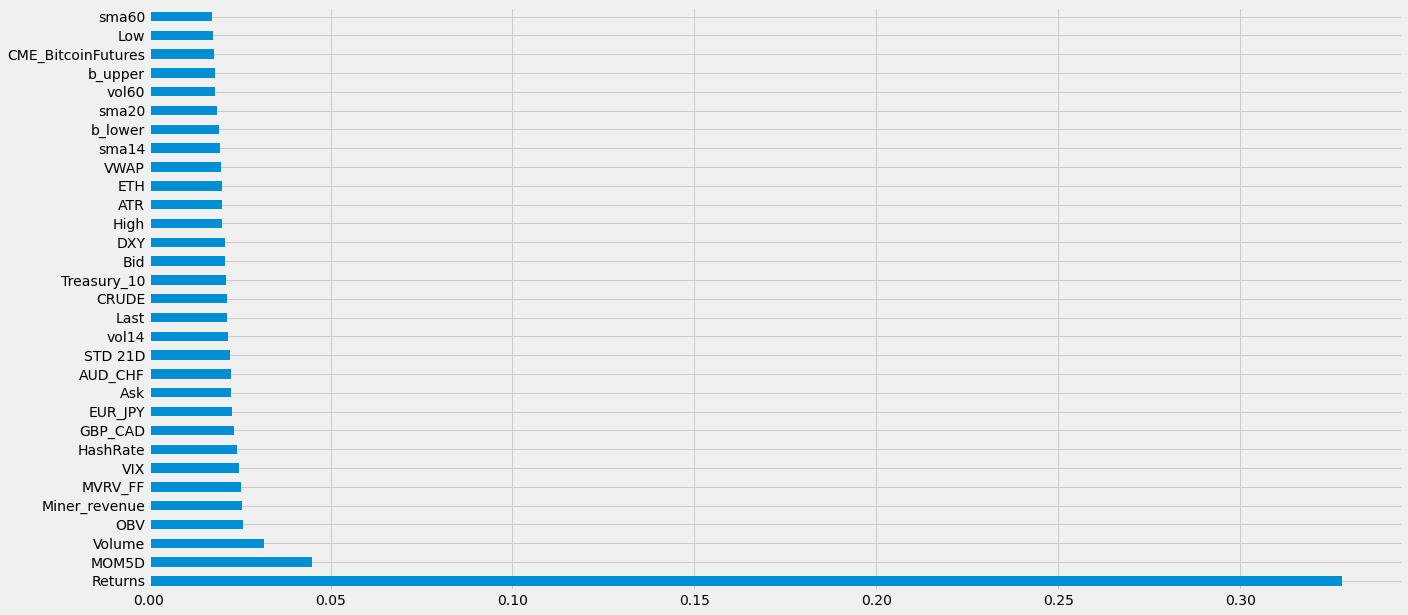

In [101]:
# FEATURE IMPORTANCE
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,Y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(len(X.keys())).plot(kind='barh')
plt.show()

#### Model selection with Probabilistic PCA and Factor Analysis (FA)

Probabilistic PCA and Factor Analysis are probabilistic models. The consequence is that the likelihood of new data can be used for model selection. Here we compare PCA and FA with cross-validation

In [102]:
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA, FactorAnalysis
n_samples, n_features, rank = len(X), len(list(X.keys())), 10
n_components = np.arange(0, len(list(X.keys())), 5)
def compute_scores(X):
    pca = PCA(svd_solver='full')
    fa = FactorAnalysis()

    pca_scores, fa_scores = [], []
    for n in n_components:
        pca.n_components = n
        fa.n_components = n
        pca_scores.append(np.mean(cross_val_score(pca, X)))
        fa_scores.append(np.mean(cross_val_score(fa, X)))

    return pca_scores, fa_scores
pca_scores, fa_scores = compute_scores(X)
n_components_pca = n_components[np.argmax(pca_scores)]
n_components_fa = n_components[np.argmax(fa_scores)]
pca = PCA(svd_solver='full', n_components='mle')
pca.fit(X)
n_components_pca_mle = pca.n_components_

print("best n_components by PCA CV = %d" % n_components_pca)
print("best n_components by FactorAnalysis CV = %d" % n_components_fa)
print("best n_components by PCA MLE = %d" % n_components_pca_mle)

plt.figure()
plt.plot(n_components, pca_scores, 'b', label='PCA scores')
plt.plot(n_components, fa_scores, 'r', label='FA scores')
plt.axvline(rank, color='g', label='TRUTH: %d' % rank, linestyle='-')
plt.axvline(n_components_pca, color='b',
                label='PCA CV: %d' % n_components_pca, linestyle='--')
plt.axvline(n_components_fa, color='r',
                label='FactorAnalysis CV: %d' % n_components_fa,
                linestyle='--')
plt.axvline(n_components_pca_mle, color='k',
                label='PCA MLE: %d' % n_components_pca_mle, linestyle='--')
plt.xlabel('nb of components')
plt.ylabel('CV scores')
plt.legend(loc='lower right')
plt.title('Factor Selection')
plt.show()

KeyboardInterrupt: 

In [ ]:
fa_scores, pca_scores
n_components

In [ ]:
X_=pca.fit_transform(X)
X_

In [ ]:
Y=pd.DataFrame(X_)
Y

In [ ]:
X

Nos quedamos con $n=5$ de las mejores features según los métodos anteriores.

In [103]:
best_feat=list(feat_importances.nlargest(5).keys())
for i in list(feat_importances.keys()):
	if(i not in best_feat):
		X.drop(i,axis=1,inplace=True)

#### Correlation Matrix
Correlation defines the similarity between random variables. In this case, we will assess correlations between features within the dataset. TRADUCIR

Miremos las correlaciones entre las features restantes

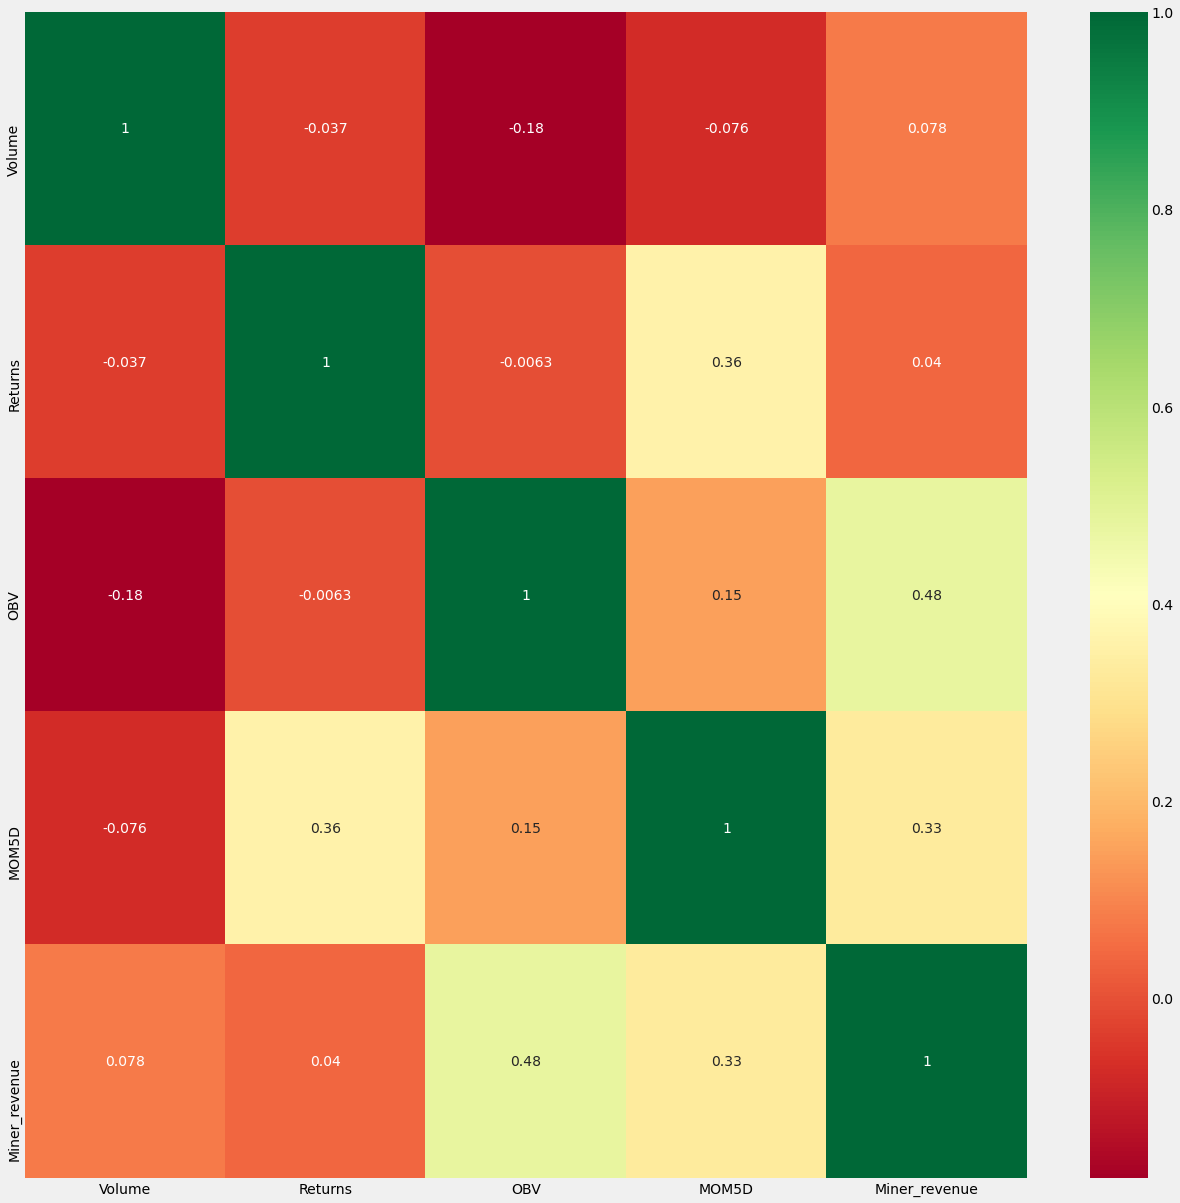

In [104]:
# Correlation Matrix with Heatmap
corrmat = X.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(X[top_corr_features].corr(),annot=True,cmap="RdYlGn")
plt.show()

#### Self Organizing Maps (SOM)
Self-organizing maps (SOM) are a class of unsupervised learning neural networks used for feature detection. SOM are used to project a high dimensional data into a smaller set and are used for dimensionality reduction.

SOMs differ from conventional artificial neural networks as they apply competitive learning when compared to error correlated learning, which involves backpropagation and gradient descent. In SOM, the training data has no labels and the map learns to differentiate and distinguish features based on similarities. TRADUCIR Y COMPLETAR

 [  1068 / 10000 ]  11% - 0:00:01 left 

 [  2066 / 10000 ]  21% - 0:00:01 left 

 [  2693 / 10000 ]  27% - 0:00:01 left 

 [  3541 / 10000 ]  35% - 0:00:01 left 

 [  4544 / 10000 ]  45% - 0:00:01 left 

 [  5613 / 10000 ]  56% - 0:00:00 left 

 [  6666 / 10000 ]  67% - 0:00:00 left 

 [  7408 / 10000 ]  74% - 0:00:00 left 

 [  8309 / 10000 ]  83% - 0:00:00 left 

 [  9082 / 10000 ]  91% - 0:00:00 left 

 [  9841 / 10000 ]  98% - 0:00:00 left 

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.3315830893110043


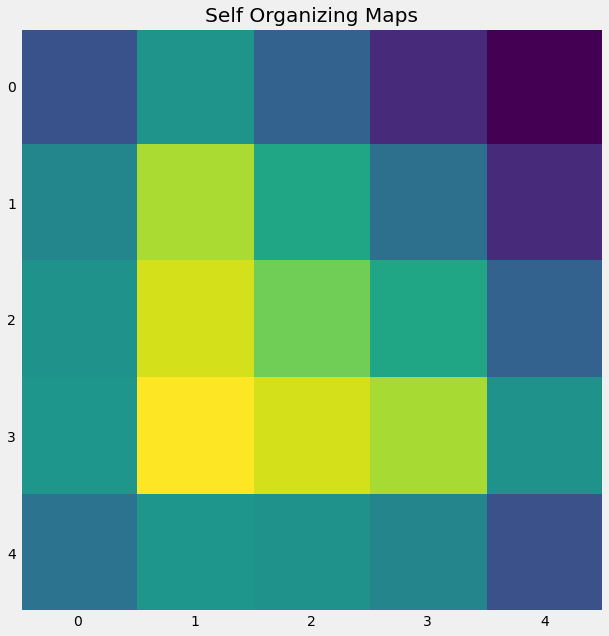

In [105]:
# SOM: basado en el lab de SOM y en https://github.com/JustGlowing/minisom/blob/master/examples/FeatureSelection.ipynb
# Import libraries
import pandas as pd
import numpy as np

# SOM & Sklearn library
from minisom import MiniSom  
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# Visualization library
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
size = len(list(X.keys()))
som = MiniSom(size, size, len(list(X.keys())), learning_rate=0.5, sigma=5, random_seed=42) 

scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)
# Initialize with randon weights 
som.random_weights_init(scaled_X) 
# Trains SOM with 10000 iterations 
som.train_batch(scaled_X,10000, verbose=True) 

# Plot SOM 
plt.figure(figsize=(20, 10)) 
for ix in range(len(scaled_X)): 
	winner = som.winner(scaled_X[ix]) 
	#plt.text(winner[0], winner[1],names[ix], bbox=dict(facecolor='white', alpha=0.5, lw=0))  
plt.imshow(som.distance_map()) 
plt.grid(False) 
plt.title('Self Organizing Maps') 
plt.show()

### <font color= darkblue> Normalizing the Dataset
Feature scaling helps the algorithm in converging the local/global minimum efficiently. Different time periods of data have different value ranges and hence we scale/normalize the data. We choose to normalize features in order to avoid feature data:

- containing features with very large values
- that is heterogeneous: when different features are on completely different scales

Otherwise, there can be large gradient updates that prevent network convergence.


#### <font color= darkblue> Data Leakage</font>
Data leakage is when information from outside the training dataset is used to create the model. This additional information can allow the model to learn or know something that it otherwise would not know and in turn invalidate the estimated performance of the model being constructed.

We will use MinMaxScaler from Sci-kit Learn. https://scikitlearn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

#### <font color= darkblue>Split the data</font>
A critical part of any machine learning study is to have a clear distinction between the data that is used to train a model and the data used to evaluate the predictive power of the model out-of-sample. Therefore, we will split our data into 2 sections.

\begin{itemize}
\item train: 70\% of data will be used for training the models;
\item test: 30\% of data will be used to evaluate the performance of the models out-of-sample.
\end{itemize}

In [106]:
# 70% train/test split
split = int(len(X) * 0.7)

# transformo Y a valores para clasificacion binaria (0 y 1)
from sklearn.preprocessing import LabelEncoder 
encoder = LabelEncoder() 
encoder.fit(Y) 
encoded_Y = encoder.transform(Y) 
# transformo encoded_Y a un dataframe para usar .iloc y poder hacer el train/test split
Y = pd.DataFrame(encoded_Y, columns = ['Column_A']) 

# Create train data set
X_train, y_train = X.iloc[split:], Y.iloc[split:]
# Test data after train split
X_test, y_test = X.iloc[:split], Y.iloc[:split]


# Scale the features MinMax for training and test datasets
scaler = MinMaxScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)
#
X_train=scaled_X_train
X_test=scaled_X_test

#### Reshaping the Data
We need to reshape the data as LSTM network consume input in a 3-dimensional array in the form of number of samples, number of time steps and number of features, while our x_train data is a 2-dimensional array.

In [107]:
# Reshaping the Data for LSTM and ALSTM
# reshaping into 3D Array
X_train_LSTM=np.array(scaled_X_train).reshape(len(scaled_X_train),1,len(list(X.keys()))) # len(scaled_train_data) samples; 1 timesteps per sample; 9 features per timestep or 1 samples; len(scaled_train_data) timesteps; 9 features per timestep?
y_train=np.array(y_train)
# Para poder fitear el modelo la primera coordenada de X_train e y_train tienen que coincidir (i.e. la cantidad de samples)
X_test_LSTM=np.array(scaled_X_test).reshape(len(scaled_X_test),1,len(list(X.keys())))
y_test=np.array(y_test)

# <font color= darkblue> Part II:  Building Models</font> 
Basado en https://medium.com/@alex.ortner.1982/top-10-binary-classification-algorithms-a-beginners-guide-feeacbd7a3e2

#### <font color= darkblue>Keras </font>
Keras is a deep learning API for Python and is one of the most powerful and easy to use library which runs on top of popular libraries like TensorFlow for creating deep learning models. In order to train and and test neural networks we will use the python package Keras which will use the tensorflow backend.

In [108]:
import numpy as np
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import load_model, Model

### 1. Naive Bayes
The Naive Bayes method is a supervised learning algorithm based on applying Bayes’ theorem with the “naive” assumption of conditional independence between every pair of features given the value of the class variable.

In [109]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB().fit(X_train, y_train)
print("score on test: " + str(mnb.score(X_test, y_test)))
print("score on train: "+ str(mnb.score(X_train, y_train)))

score on test: 0.5693848354792561
score on train: 0.5933333333333334


### 2. Logistic Regression
Logistic Regression is one of the oldest and most basic algorithms to solve a classification problem:

In [110]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
print("score on test: " + str(lr.score(X_test, y_test)))
print("score on train: "+ str(lr.score(X_train, y_train)))

score on test: 0.876967095851216
score on train: 0.8866666666666667


### 3. K-Nearest Neighbours
The k-nearest neighbors (KNN) algorithm is a supervised machine learning algorithm that can be used to solve both classification and regression problems. For KNN, it is known that it does not work so well with large datasets (high sample size) and in with many features (high dimensions) in particular. Our dataset with 25000 samples and 10000 features is already not optimal for this algorithm. I had to set two parameters, algorithm = “brute” and n_jobs=-1 to get the classifier run in a recent time.

In [111]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(algorithm = 'brute', n_jobs=-1)
knn.fit(X_train, y_train)
print("train shape: " + str(X_train.shape))
print("score on test: " + str(knn.score(X_test, y_test)))
print("score on train: "+ str(knn.score(X_train, y_train)))

train shape: (300, 5)
score on test: 0.8583690987124464
score on train: 0.9366666666666666


### 4. Support Vector Machine
The Support Vector Machine is a simple algorithm for classification and regression tasks. It can provide high accuracy with less computation power very fast. Due to the large number of features, we are using the LinearSVC. It turned out that setting the regularisation parameter C=0.0001 improves the quality of the prediction and reduces overfitting.

In [143]:
from sklearn.svm import LinearSVC
svm=LinearSVC(C=100)
svm.fit(X_train, y_train)
print("score on test: " + str(svm.score(X_test, y_test)))
print("score on train: "+ str(svm.score(X_train, y_train)))

score on test: 0.9756795422031473
score on train: 0.9933333333333333


### 5. Decision Tree
A Decision Tree is a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules (if-else) inferred from the data features.

In [113]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
print("score on test: "  + str(clf.score(X_test, y_test)))
print("score on train: " + str(clf.score(X_train, y_train)))

score on test: 1.0
score on train: 1.0


Applying a single decision tree to this feature rich dataset leads to massive overfitting. Indeed, an accuracy of 100% means it has remembered exactly the training dataset and is therefore generalising poorly on the test data. What we can see here is one of the cons of single decision tree which can’t handle data with too many features.

However, this issue can be addressed by either tuning some parameter of the algorithm or introducing ensemble learning techniques. Here you can find an in-depth article about parameter tuning of the decision tree classifier: https://medium.com/@mohtedibf/indepth-parameter-tuning-for-decision-tree-6753118a03c3. Next we will focus on some common ensemble learning approaches.

### 6. Bagging Decision Tree (Ensemble Learning I)
When a decision tree overfits, applying an ensemble learning algorithm like bagging might improve the quality of the prediction model. In bagging, the training data is increased by taking bootstraps from the training data. This means multiple samples are taken (with replacement) from the training data and the model is trained on these sub-datasets. The final prediction is the average over all predictions from each bootstrap sample.

In [114]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
# max_samples: maximum size 0.5=50% of each sample taken from the full dataset
# max_features: maximum of features 1=100% taken here all 10K 
# n_estimators: number of decision trees 
bg=BaggingClassifier(DecisionTreeClassifier(),max_samples=0.5,max_features=1.0,n_estimators=10)
bg.fit(X_train, y_train)
print("score on test: " + str(bg.score(X_test, y_test)))
print("score on train: "+ str(bg.score(X_train, y_train)))

score on test: 1.0
score on train: 1.0


### 7. Boosting Decision Tree (Ensemble Learning II)
In general, we can’t use Boosting to improve a completely overfitted model with score = 1. To apply Boosting, we first have to tweak the decision tree classifier a bit. It took me some trial and error until I got the best parameters for the Decision Tree and the AdaBoost Classifier. I am sure you can further improve by playing around a bit more.

In [115]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
adb = AdaBoostClassifier(DecisionTreeClassifier(min_samples_split=10,max_depth=4),n_estimators=10,learning_rate=0.6)
adb.fit(X_train, y_train)
print("score on test: " + str(adb.score(X_test, y_test)))
print("score on train: "+ str(adb.score(X_train, y_train)))

score on test: 1.0
score on train: 1.0


### 8. Random Forest (Ensemble Learning III)
The Random Forest Algorithm is another frequently used ensemble learning classifier which uses multiple decision trees. The Random Forest classifier is basically a modified bagging algorithm of a Decision Tree that selects the subsets differently. I found out that max_depth=9 is a good value for this feature-rich dataset.

In [116]:
from sklearn.ensemble import RandomForestClassifier
# n_estimators = number of decision trees
rf = RandomForestClassifier(n_estimators=30, max_depth=9)
rf.fit(X_train, y_train)
print("score on test: " + str(rf.score(X_test, y_test)))
print("score on train: "+ str(rf.score(X_train, y_train)))

score on test: 1.0
score on train: 1.0


### 9. Voting Classifier (Ensemble Learning IV)
This classifier from the ensemble learning toolbox evaluates different classifiers and selects the best out of it

The idea behind the VotingClassifier is to combine conceptually different machine learning classifiers and use a majority vote or the average predicted probabilities to predict the class labels. Such a classifier can be useful for a set of equally well performing models in order to balance out their individual weaknesses.
(citation from: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html)

So let’s use this classifier to combine some of the models we had so far and apply the Voting Classifier on
\begin{itemize}
\item Naive Bayes (84%, 2s);
\item Logistic Regression (86%, 60s, overfitting);
\item Random Forest (80%, 20s);
\item Support Vector Machine (85%, 10s).
\end{itemize}
Be aware that for this code snippet, all used model definitions have to be loaded in the Python kernel.

In [117]:
from sklearn.ensemble import VotingClassifier
# 1) naive bias = mnb
# 2) logistic regression =lr
# 3) random forest =rf
# 4) support vector machine = svm
evc=VotingClassifier(estimators=[('mnb',mnb),('lr',lr),('rf',rf),('svm',svm)],voting='hard')
evc.fit(X_train, y_train)
print("score on test: " + str(evc.score(X_test, y_test)))
print("score on train: "+ str(evc.score(X_train, y_train)))

score on test: 0.9170243204577968
score on train: 0.9333333333333333


### 10. PPR

In [152]:
from skpp import ProjectionPursuitRegressor
from skpp import ProjectionPursuitClassifier
import keras
# r: The number of terms in the underlying additive model. The input will be put through r projections, r functions of those projections, and then multiplication by r output vectors to determine output.
#ppr = ProjectionPursuitRegressor(r=10)
ppr = ProjectionPursuitClassifier(r=10)
fit=ppr.fit(X_train, y_train)
ppr_prediction=ppr.predict(X_test)

In [153]:
import sklearn
ppr_accuracy=sklearn.metrics.accuracy_score(y_test,ppr_prediction)
ppr_cross_entropy_loss=sklearn.metrics.log_loss(y_test, ppr_prediction)
ppr_zero_one_loss=sklearn.metrics.zero_one_loss(y_test,ppr_prediction)
print('MLP: [accuracy, crossentropy loss, zero/one loss] =', [ppr_accuracy,ppr_cross_entropy_loss, ppr_zero_one_loss])

MLP: [accuracy, crossentropy loss, zero/one loss] = [0.6909871244635193, 10.673012405018557, 0.3090128755364807]


### 11. Neural Network and Deep Learning
Deep learning uses an artificial neural network that uses multiple layers to progressively extract higher level features from the training data. We are using a simple three-layer network without any optimisation, except the usage of a small validation dataset. Here we are using Keras instead of Sklearn.

In [120]:
from keras import layers
from keras import models
from keras import optimizers
from keras import losses
from keras import metrics
model=models.Sequential()
model.add(layers.Dense(16,activation='relu',input_shape = (X_train.shape[0],X_train.shape[1])))
model.add(layers.Dense(16,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])
# 0.33 validation dataset
model.fit(X_train,y_train,epochs=4,batch_size=512,validation_split=0.33)
print("score on test: " + str(model.evaluate(X_test,y_test)[1]))
print("score on train: "+ str(model.evaluate(X_train,y_train)[1]))

Epoch 1/4
1/1 [==============================] - 1s 1s/step - loss: 0.6952 - accuracy: 0.5200 - val_loss: 0.6782 - val_accuracy: 0.6400
Epoch 2/4
1/1 [==============================] - 0s 49ms/step - loss: 0.6923 - accuracy: 0.5200 - val_loss: 0.6766 - val_accuracy: 0.6500
Epoch 3/4
1/1 [==============================] - 0s 56ms/step - loss: 0.6901 - accuracy: 0.5200 - val_loss: 0.6755 - val_accuracy: 0.6500
Epoch 4/4
22/22 [==============================] - 0s 2ms/step - loss: 0.6868 - accuracy: 0.5322
score on test: 0.5321888327598572
10/10 [==============================] - 0s 3ms/step - loss: 0.6823 - accuracy: 0.5667
score on train: 0.5666666626930237


Using a neural network leads to the best test score that we achieved so far, at around 88%. However, the standard settings lead to an overfitting of the training data.

This issue can be handled easily by adding some minor tuning parameters which reduce the training score to 0.90.
In the following, I applied the 3 best practices for handling overfitting in a neural network:

\begin{itemize}
\item reduce the network’s size;
\item adding some weight regularisation;
\item adding dropout.
\end{itemize}

In [121]:
from keras import layers
from keras import models
from keras import optimizers
from keras import losses
from keras import regularizers
from keras import metrics
model=models.Sequential()
model.add(layers.Dense(8,kernel_regularizer=regularizers.l2(0.003),activation='relu',input_shape=(X_train.shape[0],X_train.shape[1])))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(8,kernel_regularizer=regularizers.l2(0.003),activation='relu'))
model.add(layers.Dropout(0.6))
model.add(layers.Dense(1,activation='sigmoid'))
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])
model.fit(X_train,y_train,epochs=4,batch_size=512,validation_split=0.33)
print("score on test: " + str(model.evaluate(X_test,y_test)[1]))
print("score on train: "+ str(model.evaluate(X_train,y_train)[1]))

Epoch 1/4
1/1 [==============================] - 1s 1s/step - loss: 0.8187 - accuracy: 0.5350 - val_loss: 0.7066 - val_accuracy: 0.6300
Epoch 2/4
1/1 [==============================] - 0s 51ms/step - loss: 0.8228 - accuracy: 0.5100 - val_loss: 0.7066 - val_accuracy: 0.6300
Epoch 3/4
1/1 [==============================] - 0s 60ms/step - loss: 0.8010 - accuracy: 0.4950 - val_loss: 0.7071 - val_accuracy: 0.6300
Epoch 4/4
22/22 [==============================] - 0s 1ms/step - loss: 0.7373 - accuracy: 0.5322
score on test: 0.5321888327598572
10/10 [==============================] - 0s 2ms/step - loss: 0.7197 - accuracy: 0.5567
score on train: 0.5566666722297668


#### MLP

In [122]:
# MLP: mirar https://machinelearningmastery.com/binary-classification-tutorial-with-the-keras-deep-learning-library/ + https://scikit-learn.org/stable/modules/neural_networks_supervised.html
# define model

def model_MLP(optimizer,activation,loss,metrics):
  model = Sequential()

  model.add(Dense(64,  activation = activation))
  
  model.add(Dense(1, activation='sigmoid'))
  
  model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

  return model

MLP=model_MLP(optimizer='adam',activation='relu',loss='binary_crossentropy',metrics=['binary_accuracy'])  
history_MLP=MLP.fit(np.array(X_train), y_train, batch_size=len(X_train), epochs=200, verbose=2, validation_split=0.33, shuffle=False)

Epoch 1/200
1/1 - 1s - loss: 0.6819 - binary_accuracy: 0.5800 - val_loss: 0.6629 - val_binary_accuracy: 0.6300
Epoch 2/200
1/1 - 0s - loss: 0.6806 - binary_accuracy: 0.5600 - val_loss: 0.6612 - val_binary_accuracy: 0.6300
Epoch 3/200
1/1 - 0s - loss: 0.6794 - binary_accuracy: 0.5600 - val_loss: 0.6595 - val_binary_accuracy: 0.6300
Epoch 4/200
1/1 - 0s - loss: 0.6781 - binary_accuracy: 0.5550 - val_loss: 0.6579 - val_binary_accuracy: 0.6300
Epoch 5/200
1/1 - 0s - loss: 0.6769 - binary_accuracy: 0.5600 - val_loss: 0.6564 - val_binary_accuracy: 0.6300
Epoch 6/200
1/1 - 0s - loss: 0.6757 - binary_accuracy: 0.5650 - val_loss: 0.6549 - val_binary_accuracy: 0.6300
Epoch 7/200
1/1 - 0s - loss: 0.6745 - binary_accuracy: 0.5650 - val_loss: 0.6536 - val_binary_accuracy: 0.6300
Epoch 8/200
1/1 - 0s - loss: 0.6734 - binary_accuracy: 0.5700 - val_loss: 0.6524 - val_binary_accuracy: 0.6300
Epoch 9/200
1/1 - 0s - loss: 0.6723 - binary_accuracy: 0.5700 - val_loss: 0.6512 - val_binary_accuracy: 0.6300
E

Epoch 75/200
1/1 - 0s - loss: 0.6003 - binary_accuracy: 0.7850 - val_loss: 0.6001 - val_binary_accuracy: 0.6400
Epoch 76/200
1/1 - 0s - loss: 0.5993 - binary_accuracy: 0.7850 - val_loss: 0.5995 - val_binary_accuracy: 0.6400
Epoch 77/200
1/1 - 0s - loss: 0.5983 - binary_accuracy: 0.7850 - val_loss: 0.5988 - val_binary_accuracy: 0.6400
Epoch 78/200
1/1 - 0s - loss: 0.5972 - binary_accuracy: 0.7850 - val_loss: 0.5982 - val_binary_accuracy: 0.6400
Epoch 79/200
1/1 - 0s - loss: 0.5962 - binary_accuracy: 0.7950 - val_loss: 0.5975 - val_binary_accuracy: 0.6400
Epoch 80/200
1/1 - 0s - loss: 0.5951 - binary_accuracy: 0.7900 - val_loss: 0.5969 - val_binary_accuracy: 0.6400
Epoch 81/200
1/1 - 0s - loss: 0.5941 - binary_accuracy: 0.7900 - val_loss: 0.5962 - val_binary_accuracy: 0.6400
Epoch 82/200
1/1 - 0s - loss: 0.5930 - binary_accuracy: 0.7900 - val_loss: 0.5956 - val_binary_accuracy: 0.6400
Epoch 83/200
1/1 - 0s - loss: 0.5919 - binary_accuracy: 0.7900 - val_loss: 0.5949 - val_binary_accuracy:

Epoch 148/200
1/1 - 0s - loss: 0.5221 - binary_accuracy: 0.8100 - val_loss: 0.5521 - val_binary_accuracy: 0.6800
Epoch 149/200
1/1 - 0s - loss: 0.5210 - binary_accuracy: 0.8100 - val_loss: 0.5515 - val_binary_accuracy: 0.6800
Epoch 150/200
1/1 - 0s - loss: 0.5199 - binary_accuracy: 0.8100 - val_loss: 0.5508 - val_binary_accuracy: 0.6800
Epoch 151/200
1/1 - 0s - loss: 0.5188 - binary_accuracy: 0.8150 - val_loss: 0.5501 - val_binary_accuracy: 0.6800
Epoch 152/200
1/1 - 0s - loss: 0.5178 - binary_accuracy: 0.8150 - val_loss: 0.5494 - val_binary_accuracy: 0.6800
Epoch 153/200
1/1 - 0s - loss: 0.5167 - binary_accuracy: 0.8150 - val_loss: 0.5487 - val_binary_accuracy: 0.6800
Epoch 154/200
1/1 - 0s - loss: 0.5156 - binary_accuracy: 0.8150 - val_loss: 0.5480 - val_binary_accuracy: 0.6800
Epoch 155/200
1/1 - 0s - loss: 0.5144 - binary_accuracy: 0.8150 - val_loss: 0.5473 - val_binary_accuracy: 0.6800
Epoch 156/200
1/1 - 0s - loss: 0.5133 - binary_accuracy: 0.8150 - val_loss: 0.5466 - val_binary_

In [123]:
print(MLP.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 64)                384       
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 65        
Total params: 449
Trainable params: 449
Non-trainable params: 0
_________________________________________________________________
None


### LSTM

### <font color= darkblue>Building an LSTM Model </font>

In buiding neural networks, we would be cautious on deploying too many neurons/layers, especially if the data set is not particularly large. While in-sample fit will inevitably increase, too many parameters increases the risk of overfitting. Additionally, the training (optimization) process becomes much more computationally intensive and the risk of non-convergence increases.  

One important point to consider is the fact that when training with noisy data (such as financial time-series) it is important to build a Neural Network that is not excessively complex, or uses other mechanisms such as drop-out, to help avoid over-fitting.


In this section, we show how to build an LSTM neural network in Python from scratch, using only base Python functions. 

#### <font color= darkblue> Define Model
A neural network is made up of two parts. The choice of the number of neurons, hidden layers, and activation functions determines how $x$ variables are transformed into $y$, given some fixed weights. The transformation process is known as the
forward propagation step.

First, we define the LSTM Recurrent Neural Network by initializing the Sequential Model. We'll add more LSTM layers and adjust the Dropout in order to improve the accuracy of our model. Finally, a Dense layer is used as output layer.

Next, we compile and train the model defined below. Iteratively, we can increase or decrease the epochs and batch size to get more accuracy.

#### <font color= darkblue> LSTM Model Creation </font>

Similar to Sklearn, the core data structure used in Keras is a model. The simplest type of model is the Sequential model which is a simple linear stack of layers.




We define a model\_() function to build a LSTM model in Keras with a specified number of hidden layers (hidden\_layers), each with a specified number of neurons (neurons) and a dropout percentage (drop_pct).The function returns the compiled model.The edge of the code presented below is the possibility of easily implement any change that need to be done without re-writing entire bits of the code script. 



In [124]:
def model_LSTM_(optimizer,activation,loss,metrics):
  model = Sequential()

  model.add(LSTM(units=256, input_shape = (X_train_LSTM.shape[1],X_train_LSTM.shape[2]), return_sequences=True)) 
  model.add(Dropout(0.4, seed=seed_value))

  model.add(LSTM(units=256, return_sequences=True))
  model.add(Dropout(0.4, seed=seed_value))

  model.add(LSTM(units=64, return_sequences=False))
  model.add(Dropout(0.4, seed=seed_value))

  model.add(Dense(64,  activation = activation))
  
  model.add(Dense(1, activation='sigmoid'))
  
  model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

  return model

# Define the Model
model_LSTM=model_LSTM_(optimizer='adam',activation='relu',loss='binary_crossentropy',metrics=['binary_accuracy'])

#### <font color= darkblue> Fitting the Model</font>

The classic Stochastic gradient descent (SGD) method has been enhanced by various adaptive moment estimation (ADAM) techniques that build on AdaGrad and RMSProp \& others. There is also some *Practical Advice for Building Deep Neural Networks* by Matt H and Daniel R that explains why the ADAM optimiser, ReLU activation function and variance scaled initialisation are preferred.
 
 In fact, while Stochastic Gradient Descent is used in many Neural Network problems, it has the problem of converging to a local minimum. This of course presents a problem considering Bitcoin price. Some other nice optimizers are variations of adaptive learning algorithms, like Adam, Adagrad, and RMSProp. Adam was found to work slightly better than the rest.

In [125]:
history_LSTM=model_LSTM.fit(X_train_LSTM, y_train, batch_size=len(X_train_LSTM), epochs=200, verbose=2, validation_split=0.33, shuffle=False)

Epoch 1/200
1/1 - 8s - loss: 0.6932 - binary_accuracy: 0.4950 - val_loss: 0.6924 - val_binary_accuracy: 0.6300
Epoch 2/200
1/1 - 0s - loss: 0.6930 - binary_accuracy: 0.5200 - val_loss: 0.6917 - val_binary_accuracy: 0.6300
Epoch 3/200
1/1 - 0s - loss: 0.6929 - binary_accuracy: 0.5200 - val_loss: 0.6908 - val_binary_accuracy: 0.6300
Epoch 4/200
1/1 - 0s - loss: 0.6926 - binary_accuracy: 0.5200 - val_loss: 0.6899 - val_binary_accuracy: 0.6300
Epoch 5/200
1/1 - 0s - loss: 0.6924 - binary_accuracy: 0.5200 - val_loss: 0.6891 - val_binary_accuracy: 0.6300
Epoch 6/200
1/1 - 0s - loss: 0.6920 - binary_accuracy: 0.5200 - val_loss: 0.6882 - val_binary_accuracy: 0.6300
Epoch 7/200
1/1 - 0s - loss: 0.6920 - binary_accuracy: 0.5200 - val_loss: 0.6872 - val_binary_accuracy: 0.6300
Epoch 8/200
1/1 - 0s - loss: 0.6917 - binary_accuracy: 0.5200 - val_loss: 0.6862 - val_binary_accuracy: 0.6300
Epoch 9/200
1/1 - 0s - loss: 0.6918 - binary_accuracy: 0.5200 - val_loss: 0.6853 - val_binary_accuracy: 0.6300
E

Epoch 75/200
1/1 - 0s - loss: 0.1679 - binary_accuracy: 0.9400 - val_loss: 0.2061 - val_binary_accuracy: 0.8700
Epoch 76/200
1/1 - 0s - loss: 0.1886 - binary_accuracy: 0.9400 - val_loss: 0.1965 - val_binary_accuracy: 0.8700
Epoch 77/200
1/1 - 0s - loss: 0.1781 - binary_accuracy: 0.9200 - val_loss: 0.1883 - val_binary_accuracy: 0.8700
Epoch 78/200
1/1 - 0s - loss: 0.1876 - binary_accuracy: 0.9300 - val_loss: 0.1819 - val_binary_accuracy: 0.8700
Epoch 79/200
1/1 - 0s - loss: 0.1308 - binary_accuracy: 0.9500 - val_loss: 0.1743 - val_binary_accuracy: 0.8700
Epoch 80/200
1/1 - 0s - loss: 0.1497 - binary_accuracy: 0.9400 - val_loss: 0.1646 - val_binary_accuracy: 0.9600
Epoch 81/200
1/1 - 0s - loss: 0.1465 - binary_accuracy: 0.9500 - val_loss: 0.1676 - val_binary_accuracy: 0.9700
Epoch 82/200
1/1 - 0s - loss: 0.1344 - binary_accuracy: 0.9550 - val_loss: 0.1630 - val_binary_accuracy: 0.9700
Epoch 83/200
1/1 - 0s - loss: 0.1224 - binary_accuracy: 0.9650 - val_loss: 0.1569 - val_binary_accuracy:

Epoch 148/200
1/1 - 0s - loss: 0.0907 - binary_accuracy: 0.9650 - val_loss: 0.0949 - val_binary_accuracy: 0.9700
Epoch 149/200
1/1 - 0s - loss: 0.0867 - binary_accuracy: 0.9650 - val_loss: 0.1401 - val_binary_accuracy: 0.9200
Epoch 150/200
1/1 - 0s - loss: 0.0547 - binary_accuracy: 0.9750 - val_loss: 0.2000 - val_binary_accuracy: 0.9000
Epoch 151/200
1/1 - 0s - loss: 0.0777 - binary_accuracy: 0.9600 - val_loss: 0.2040 - val_binary_accuracy: 0.9000
Epoch 152/200
1/1 - 0s - loss: 0.0422 - binary_accuracy: 0.9800 - val_loss: 0.1737 - val_binary_accuracy: 0.9000
Epoch 153/200
1/1 - 0s - loss: 0.0722 - binary_accuracy: 0.9600 - val_loss: 0.1216 - val_binary_accuracy: 0.9300
Epoch 154/200
1/1 - 0s - loss: 0.0582 - binary_accuracy: 0.9800 - val_loss: 0.1068 - val_binary_accuracy: 0.9500
Epoch 155/200
1/1 - 0s - loss: 0.0780 - binary_accuracy: 0.9700 - val_loss: 0.1164 - val_binary_accuracy: 0.9400
Epoch 156/200
1/1 - 0s - loss: 0.0763 - binary_accuracy: 0.9850 - val_loss: 0.1449 - val_binary_

In [126]:
print(model_LSTM.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 1, 256)            268288    
_________________________________________________________________
dropout_8 (Dropout)          (None, 1, 256)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 1, 256)            525312    
_________________________________________________________________
dropout_9 (Dropout)          (None, 1, 256)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                82176     
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 64)               

### ALSTM

In [127]:
#from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, LSTM
#from tensorflow.keras.models import load_model, Model
from attention import Attention
def model_ALSTM(optimizer,activation,loss,metrics):
  model = Sequential()

  model.add(LSTM(units=256, input_shape = (X_train_LSTM.shape[1],X_train_LSTM.shape[2]), return_sequences=True)) 
  model.add(Dropout(0.4, seed=seed_value))

  model.add(Attention(128))

  # model.add(LSTM(units=256, return_sequences=True))
  # model.add(Dropout(0.4, seed=seed_value))

  # model.add(LSTM(units=64, return_sequences=False))
  # model.add(Dropout(0.4, seed=seed_value))

  model.add(Dense(64,  activation = activation))
  
  model.add(Dense(1, activation='sigmoid'))
  
  model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

  return model

# Define the Model
ALSTM=model_ALSTM(optimizer='adam',activation='relu',loss='binary_crossentropy',metrics=['binary_accuracy'])  
history_ALSTM=ALSTM.fit(X_train_LSTM, y_train, batch_size=len(X_train_LSTM), epochs=200, verbose=2, validation_split=0.33, shuffle=False)

Epoch 1/200
1/1 - 3s - loss: 0.6932 - binary_accuracy: 0.4950 - val_loss: 0.6881 - val_binary_accuracy: 0.6300
Epoch 2/200
1/1 - 0s - loss: 0.6892 - binary_accuracy: 0.6850 - val_loss: 0.6844 - val_binary_accuracy: 0.6300
Epoch 3/200
1/1 - 0s - loss: 0.6872 - binary_accuracy: 0.5850 - val_loss: 0.6809 - val_binary_accuracy: 0.6300
Epoch 4/200
1/1 - 0s - loss: 0.6844 - binary_accuracy: 0.5850 - val_loss: 0.6770 - val_binary_accuracy: 0.6300
Epoch 5/200
1/1 - 0s - loss: 0.6796 - binary_accuracy: 0.6000 - val_loss: 0.6724 - val_binary_accuracy: 0.6300
Epoch 6/200
1/1 - 0s - loss: 0.6761 - binary_accuracy: 0.6000 - val_loss: 0.6675 - val_binary_accuracy: 0.6300
Epoch 7/200
1/1 - 0s - loss: 0.6707 - binary_accuracy: 0.6100 - val_loss: 0.6625 - val_binary_accuracy: 0.6300
Epoch 8/200
1/1 - 0s - loss: 0.6672 - binary_accuracy: 0.6350 - val_loss: 0.6573 - val_binary_accuracy: 0.6300
Epoch 9/200
1/1 - 0s - loss: 0.6607 - binary_accuracy: 0.6600 - val_loss: 0.6520 - val_binary_accuracy: 0.6300
E

Epoch 75/200
1/1 - 0s - loss: 0.1033 - binary_accuracy: 0.9800 - val_loss: 0.1479 - val_binary_accuracy: 0.9700
Epoch 76/200
1/1 - 0s - loss: 0.1360 - binary_accuracy: 0.9350 - val_loss: 0.1527 - val_binary_accuracy: 0.9600
Epoch 77/200
1/1 - 0s - loss: 0.1156 - binary_accuracy: 0.9650 - val_loss: 0.1604 - val_binary_accuracy: 0.9400
Epoch 78/200
1/1 - 0s - loss: 0.1147 - binary_accuracy: 0.9550 - val_loss: 0.1569 - val_binary_accuracy: 0.9400
Epoch 79/200
1/1 - 0s - loss: 0.1066 - binary_accuracy: 0.9600 - val_loss: 0.1528 - val_binary_accuracy: 0.9500
Epoch 80/200
1/1 - 0s - loss: 0.1064 - binary_accuracy: 0.9650 - val_loss: 0.1450 - val_binary_accuracy: 0.9600
Epoch 81/200
1/1 - 0s - loss: 0.1100 - binary_accuracy: 0.9700 - val_loss: 0.1486 - val_binary_accuracy: 0.9500
Epoch 82/200
1/1 - 0s - loss: 0.0989 - binary_accuracy: 0.9800 - val_loss: 0.1622 - val_binary_accuracy: 0.9300
Epoch 83/200
1/1 - 0s - loss: 0.1166 - binary_accuracy: 0.9450 - val_loss: 0.1483 - val_binary_accuracy:

Epoch 148/200
1/1 - 0s - loss: 0.0739 - binary_accuracy: 0.9700 - val_loss: 0.1594 - val_binary_accuracy: 0.9200
Epoch 149/200
1/1 - 0s - loss: 0.0724 - binary_accuracy: 0.9550 - val_loss: 0.1333 - val_binary_accuracy: 0.9300
Epoch 150/200
1/1 - 0s - loss: 0.0414 - binary_accuracy: 0.9950 - val_loss: 0.1244 - val_binary_accuracy: 0.9400
Epoch 151/200
1/1 - 0s - loss: 0.0523 - binary_accuracy: 0.9800 - val_loss: 0.1344 - val_binary_accuracy: 0.9300
Epoch 152/200
1/1 - 0s - loss: 0.0601 - binary_accuracy: 0.9700 - val_loss: 0.1662 - val_binary_accuracy: 0.9200
Epoch 153/200
1/1 - 0s - loss: 0.0463 - binary_accuracy: 0.9850 - val_loss: 0.1948 - val_binary_accuracy: 0.8900
Epoch 154/200
1/1 - 0s - loss: 0.0640 - binary_accuracy: 0.9700 - val_loss: 0.1708 - val_binary_accuracy: 0.9100
Epoch 155/200
1/1 - 0s - loss: 0.0483 - binary_accuracy: 0.9900 - val_loss: 0.1463 - val_binary_accuracy: 0.9200
Epoch 156/200
1/1 - 0s - loss: 0.0474 - binary_accuracy: 0.9800 - val_loss: 0.1394 - val_binary_

In [128]:
print(ALSTM.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 1, 256)            268288    
_________________________________________________________________
dropout_11 (Dropout)         (None, 1, 256)            0         
_________________________________________________________________
last_hidden_state (Lambda)   (None, 256)               0         
_________________________________________________________________
attention_score_vec (Dense)  (None, 1, 256)            65536     
_________________________________________________________________
attention_score (Dot)        (None, 1)                 0         
_________________________________________________________________
attention_weight (Activation (None, 1)                 0         
_________________________________________________________________
context_vector (Dot)         (None, 256)              

### Visualize the training and validation loss

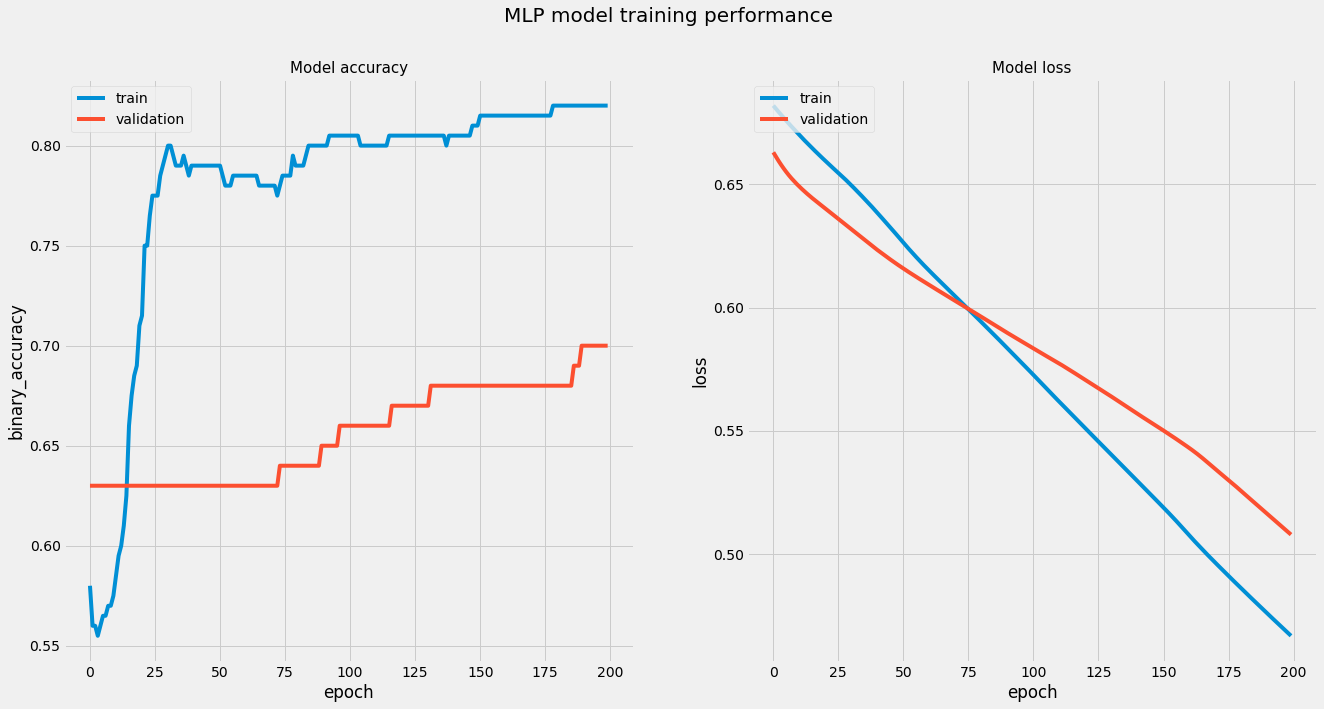

In [129]:
# MLP
fig, axs = plt.subplots(1,2)
fig.suptitle('MLP model training performance', fontsize=20)
axs[0].plot(history_MLP.history['binary_accuracy'])
axs[0].plot(history_MLP.history['val_binary_accuracy'])
axs[0].set_title('Model accuracy', fontsize=15)
axs[0].set_ylabel('binary_accuracy')
axs[0].set_xlabel('epoch')
axs[0].legend(['train', 'validation'], loc='upper left')
axs[1].plot(history_MLP.history['loss'])
axs[1].plot(history_MLP.history['val_loss'])
axs[1].set_title('Model loss', fontsize=15)
axs[1].set_ylabel('loss')
axs[1].set_xlabel('epoch')
axs[1].legend(['train', 'validation'], loc='upper left')
plt.show()

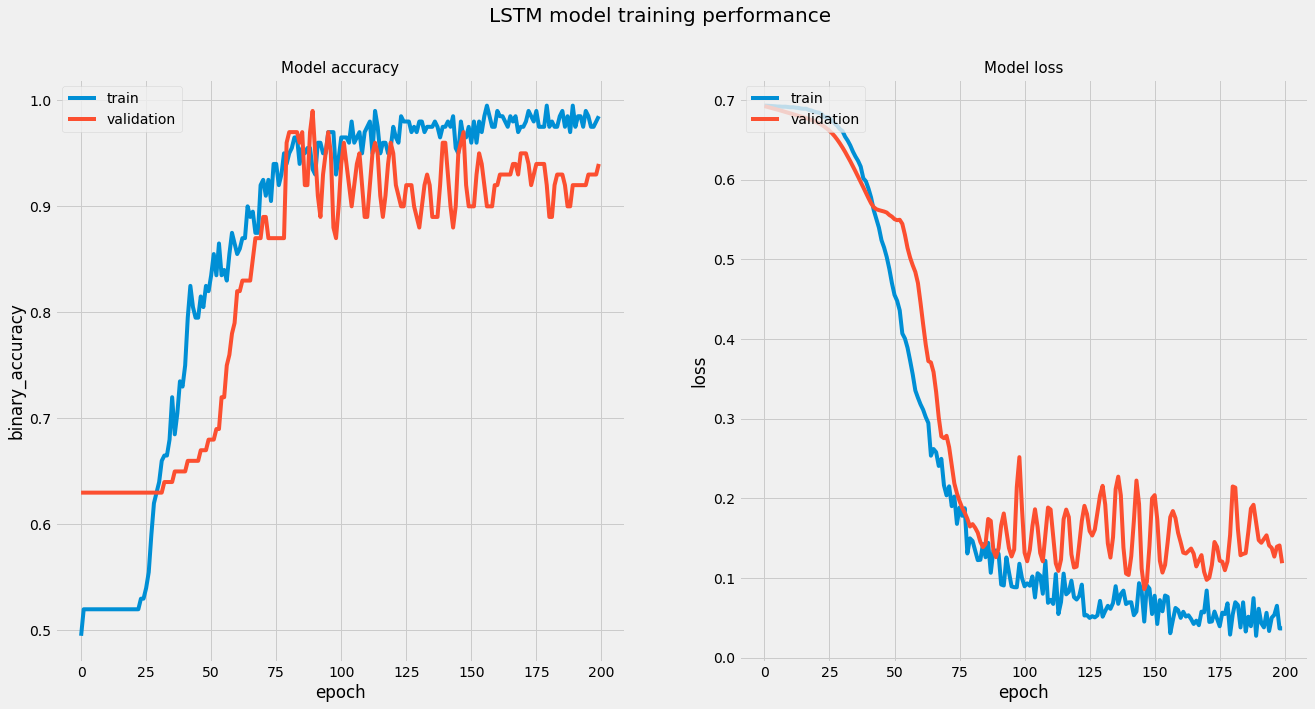

In [130]:
# LSTM
fig, axs = plt.subplots(1,2)
fig.suptitle('LSTM model training performance', fontsize=20)
axs[0].plot(history_LSTM.history['binary_accuracy'])
axs[0].plot(history_LSTM.history['val_binary_accuracy'])
axs[0].set_title('Model accuracy', fontsize=15)
axs[0].set_ylabel('binary_accuracy')
axs[0].set_xlabel('epoch')
axs[0].legend(['train', 'validation'], loc='upper left')
axs[1].plot(history_LSTM.history['loss'])
axs[1].plot(history_LSTM.history['val_loss'])
axs[1].set_title('Model loss', fontsize=15)
axs[1].set_ylabel('loss')
axs[1].set_xlabel('epoch')
axs[1].legend(['train', 'validation'], loc='upper left')
plt.show()

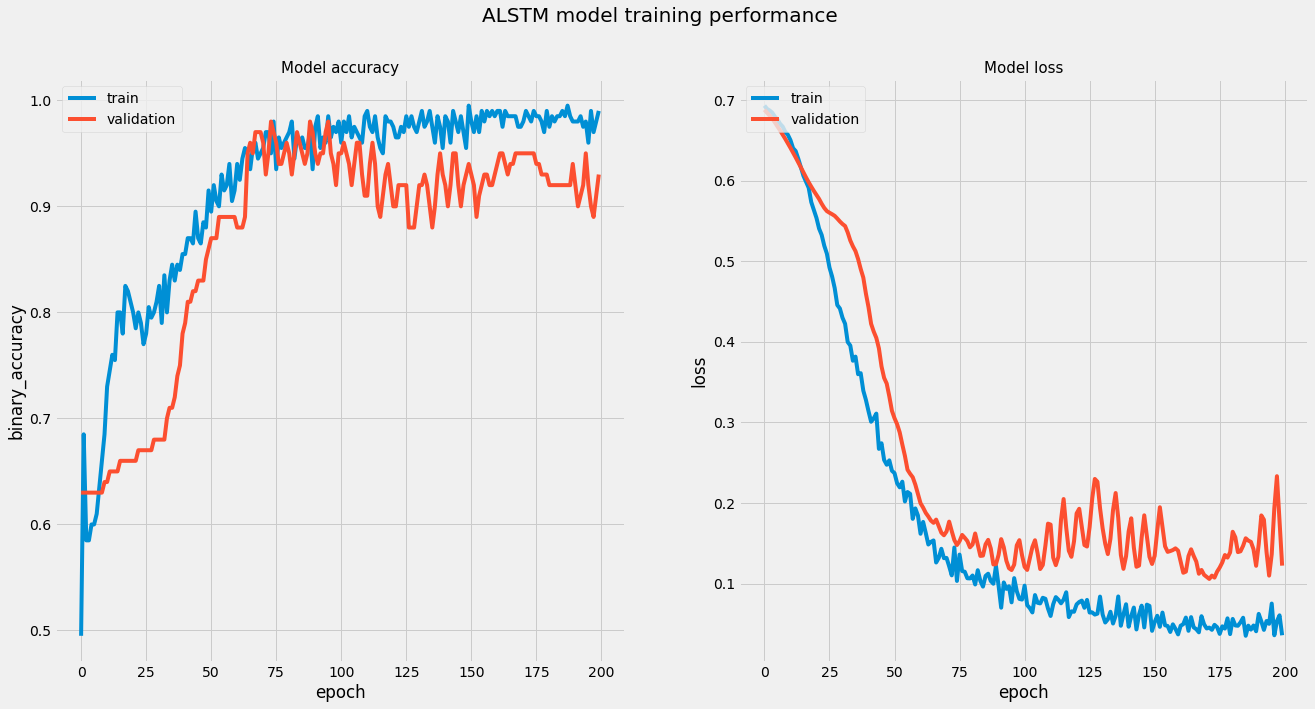

In [131]:
# ALSTM
fig, axs = plt.subplots(1,2)
fig.suptitle('ALSTM model training performance', fontsize=20)
axs[0].plot(history_ALSTM.history['binary_accuracy'])
axs[0].plot(history_ALSTM.history['val_binary_accuracy'])
axs[0].set_title('Model accuracy', fontsize=15)
axs[0].set_ylabel('binary_accuracy')
axs[0].set_xlabel('epoch')
axs[0].legend(['train', 'validation'], loc='upper left')
axs[1].plot(history_ALSTM.history['loss'])
axs[1].plot(history_ALSTM.history['val_loss'])
axs[1].set_title('Model loss', fontsize=15)
axs[1].set_ylabel('loss')
axs[1].set_xlabel('epoch')
axs[1].legend(['train', 'validation'], loc='upper left')
plt.show()

### Predicción
Now that the model is trained, it needs to be tested on the test dataset. We used Root Square Mean Error (RMSE), which is a frequently used measure of the differences between actual values and forecast values.

In [132]:
# MLP
y_pred_proba_MLP=MLP.predict_proba(X_test, batch_size=1)
# LSTM
y_pred_proba_LSTM=model_LSTM.predict_proba(X_test_LSTM, batch_size=1)
# ALSTM
y_pred_proba_ALSTM=ALSTM.predict_proba(X_test_LSTM, batch_size=1)

#### Metricas de la predicción

In [133]:
# MLP
results_MLP=MLP.evaluate(X_test, y_test)
print('MLP: [binary_crossentropy, binary_accuracy] =', results_MLP)

22/22 [==============================] - 0s 1ms/step - loss: 0.5898 - binary_accuracy: 0.6423
MLP: [binary_crossentropy, binary_accuracy] = [0.5897520780563354, 0.642346203327179]


In [134]:
# LSTM
results_LSTM=model_LSTM.evaluate(X_test_LSTM, y_test)
print('LSTM: [binary_crossentropy, binary_accuracy] =', results_LSTM)

22/22 [==============================] - 0s 6ms/step - loss: 0.1493 - binary_accuracy: 0.9299
LSTM: [binary_crossentropy, binary_accuracy] = [0.14926137030124664, 0.9298998713493347]


In [135]:
# ALSTM
results_ALSTM=ALSTM.evaluate(X_test_LSTM, y_test)
print('ALSTM: [binary_crossentropy, binary_accuracy] =', results_ALSTM)

22/22 [==============================] - 0s 3ms/step - loss: 0.4011 - binary_accuracy: 0.8326
ALSTM: [binary_crossentropy, binary_accuracy] = [0.40112295746803284, 0.832617998123169]


#### ROCs Curves

No Skill: ROC AUC=0.500
LSTM: ROC AUC=0.869


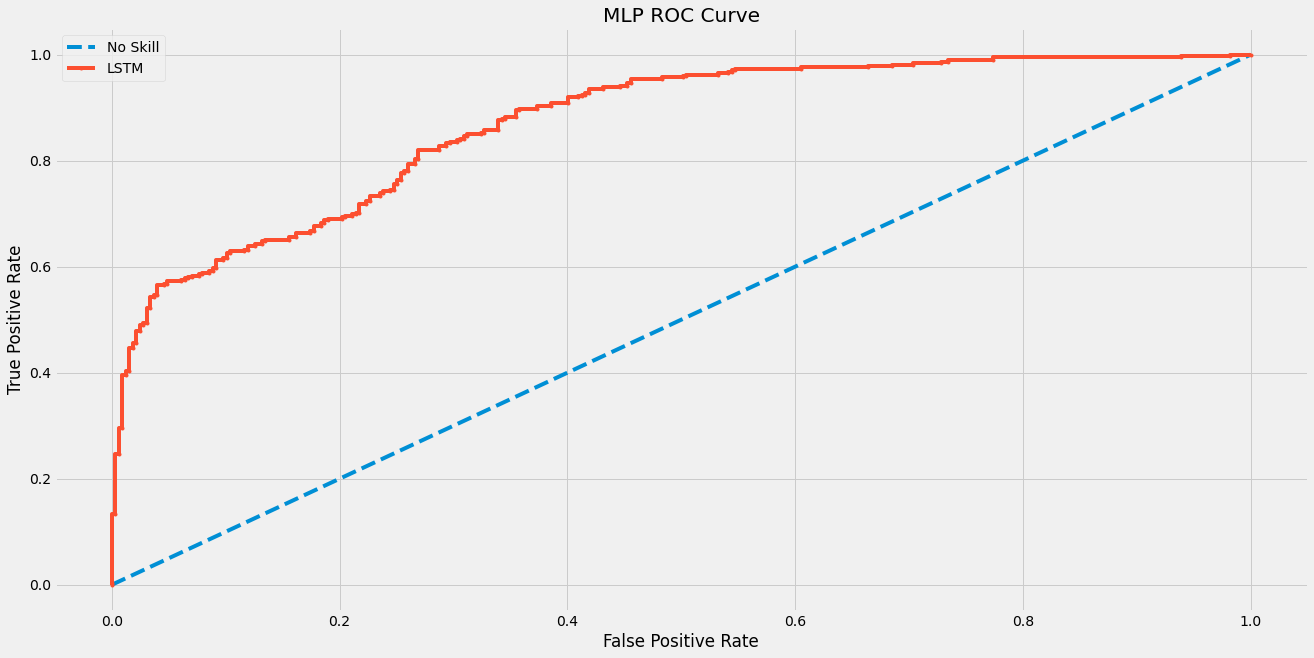

In [136]:
# MLP
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
lr_probs = y_pred_proba_MLP
#lr_probs = model.predict_proba(X_train)
ns_probs = [0 for _ in range(len(y_test))]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('LSTM: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='LSTM')
plt.title('MLP ROC Curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.savefig('ROC.png')
plt.show()

No Skill: ROC AUC=0.500
LSTM: ROC AUC=0.998


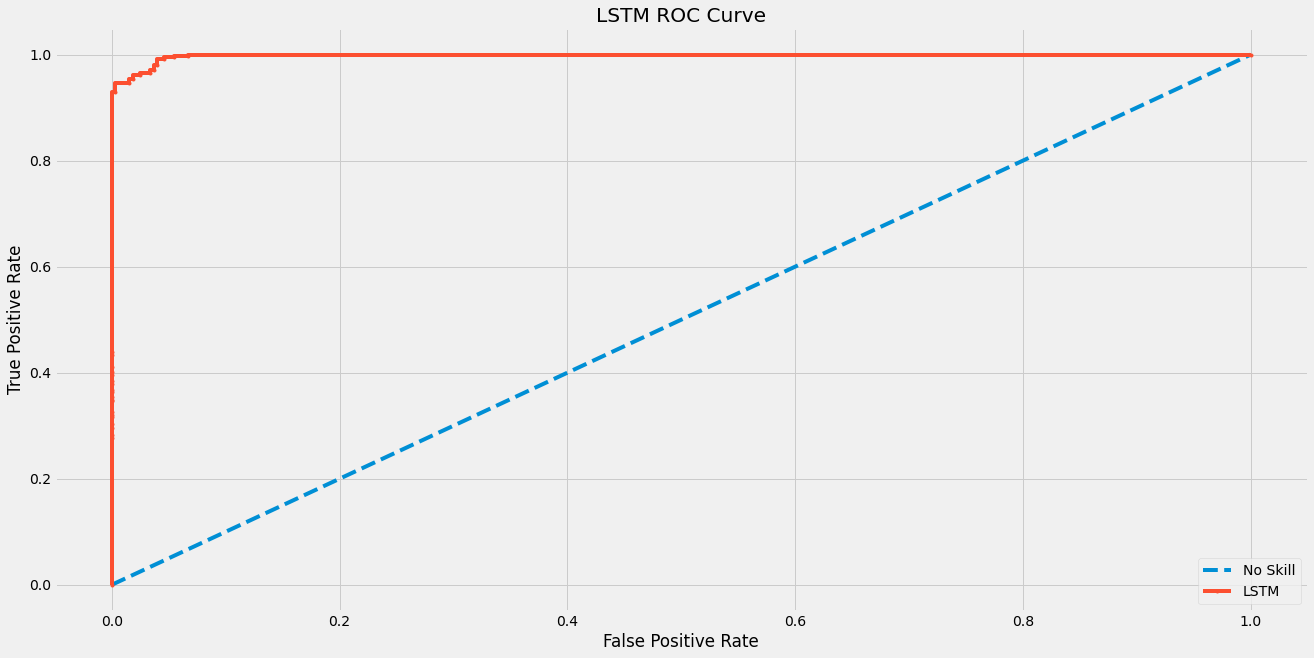

In [137]:
# LSTM
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
lr_probs = y_pred_proba_LSTM
#lr_probs = model.predict_proba(X_train)
ns_probs = [0 for _ in range(len(y_test))]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('LSTM: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='LSTM')
plt.title('LSTM ROC Curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.savefig('ROC.png')
plt.show()

No Skill: ROC AUC=0.500
LSTM: ROC AUC=0.997


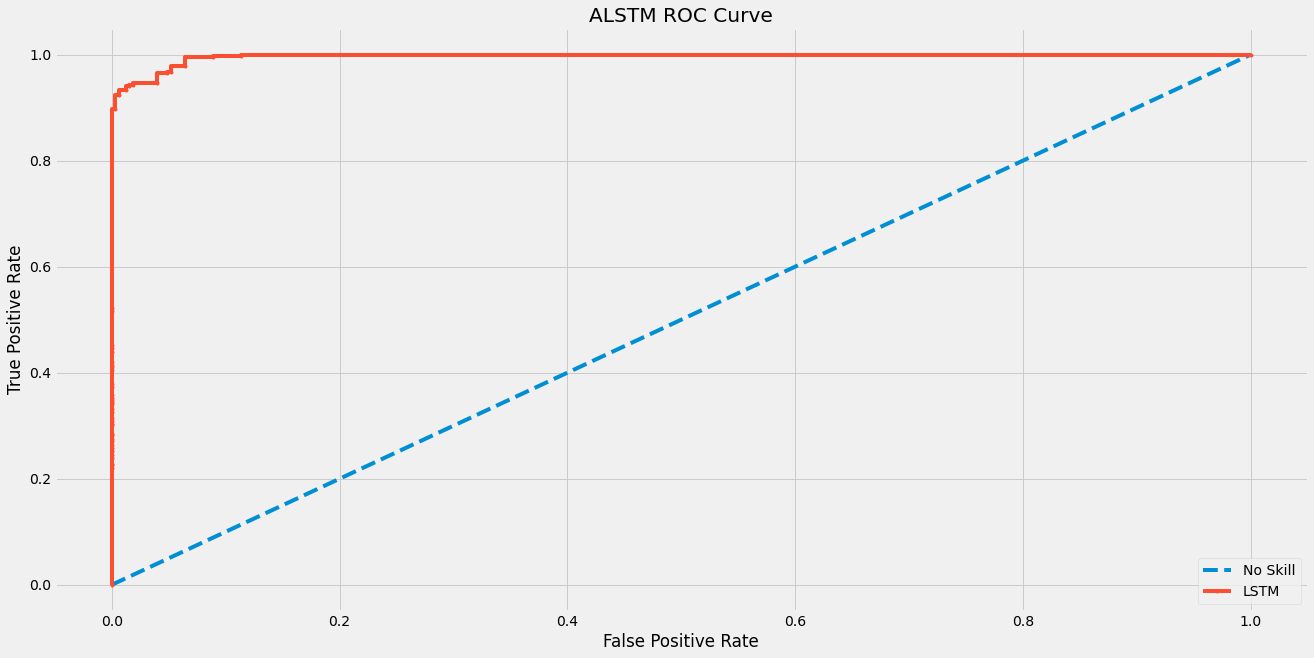

In [138]:
# ALSTM
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
lr_probs = y_pred_proba_ALSTM
#lr_probs = model.predict_proba(X_train)
ns_probs = [0 for _ in range(len(y_test))]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('LSTM: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='LSTM')
plt.title('ALSTM ROC Curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.savefig('ROC.png')
plt.show()

### Summary
We now trained 10 different machine learning algorithms on the same dataset to solve the same task, predicting a positive or negative review based on a sentiment analysis of text passages. So let’s see who wins in terms of the quality of the prediction and in run time. The parameter overfitting (OF) is just the difference from train score to test score. If it is large, it means we have high overfitting. COMPLETAR CON LA TABLA

#### Best Runtime:
In terms of Runtime, the fastest algorithms are Naive Bayes, Support Vector Machine, Voting Classifier and the Neural Network.

#### Best Prediction Score:
In terms of the best prediction of the test dataset, the best algorithms are Logistic Regression, Voting Classifier and Neural Network.

#### Worst Overfitting:
The algorithms that are overfitting the most are Logistic Regression, K-Nearest Neighbours, Decision Tree and Bagging Decision Tree.

#### Best Algorithm:
The overall best approach to solve this text sentiment analysis task is the Neural Network, which is fast, has high accuracy and low overfitting. A little bit faster but a bit worse in prediction quality is the Voting Classifier.

#### Predicción vs Realidad
TERMINAR Y ARREGLAR EL ALGO

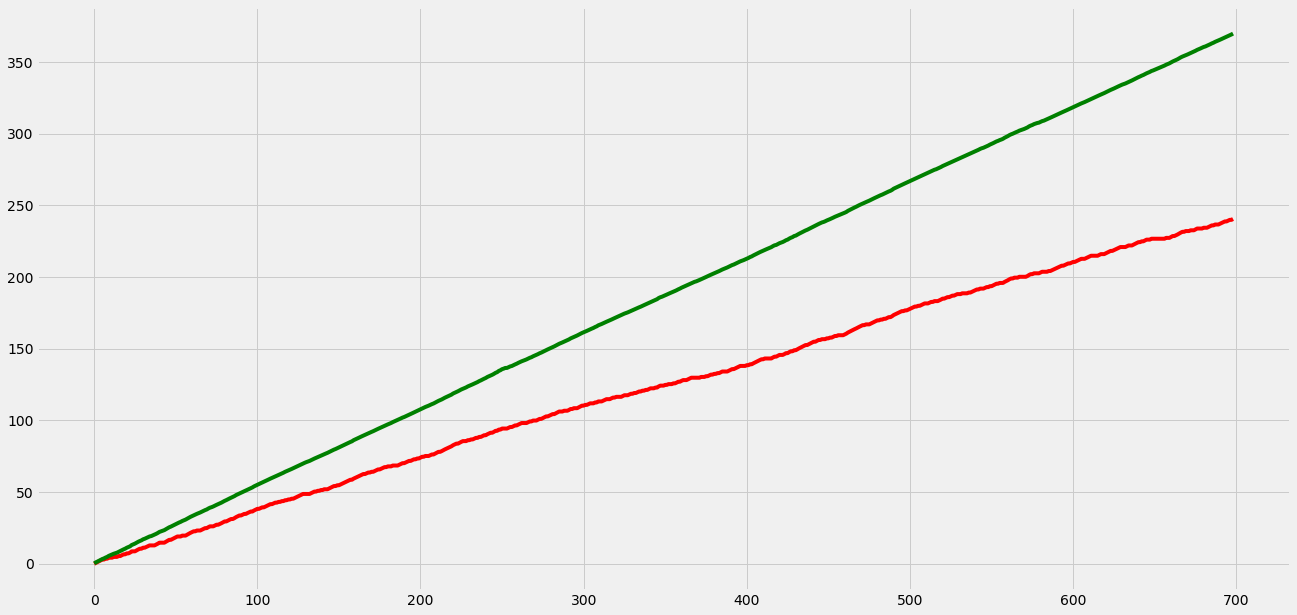

In [139]:
# Plot pred vs actual
# LSTM
C=[]
for b in y_pred_proba_LSTM:
  if(b[0]>=0.5):
    C.append(1)
  else:
    C.append(0)
daily_returns = X[:len(X_test_LSTM)]['Returns']
strategy = daily_returns * C
# Plot the cumulative daily returns (pred vs actual) 
strategy.cumsum().plot(color='red')
daily_returns.cumsum().plot(color='green')
plt.show()